![title](banner.jpg)

# Libraries and Data Loading
## Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import h5py
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

## Load up the data from h5 files

In [4]:
###################################################
# Run this only if you have the h5 files
# and don't want to process all the images again.
###################################################

with h5py.File('data_train.h5', 'r') as hf:
    train_imgs = np.array(hf['imgs'])
    train_labels = np.array(hf['labels'])


with h5py.File('data_test.h5', 'r') as hf:
    test_imgs = np.array(hf['imgs'])
    test_labels = np.array(hf['labels'])

In [5]:
test_labels

array(['normal', 'normal', 'normal', ..., 'pneumonia', 'pneumonia',
       'pneumonia'], dtype=object)

### Training dataset shape

In [6]:
train_imgs.shape

(13942, 128, 128)

In [7]:
test_imgs.shape

(1579, 128, 128)

In [8]:
def visualize_image(IMG_SET, IMG_LBL):
    try:
        if len(IMG_SET.shape) == 3:
            fig = plt.figure(figsize=(15,10))
            for i in range(10):
                ax = fig.add_subplot(1, 10, i+1)
                ax.imshow(IMG_SET[i])
                ax.set_title('label: '+str(IMG_LBL[i]))

                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            fig.tight_layout()
            plt.show()
        
        elif len(IMG_SET.shape) == 2:
            fig = plt.figure(figsize=(15,10))
            HEIGHT = WIDTH = int(np.sqrt(IMG_SET.shape[1]))
            imgs = np.reshape(IMG_SET, (len(IMG_SET), HEIGHT, WIDTH))
            for i in range(10):
                ax = fig.add_subplot(1, 10, i+1)
                ax.imshow(imgs[i])
                ax.set_title('label: '+str(IMG_LBL[i]))

                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            fig.tight_layout()
            plt.show()
        else:
            print('PLEASE PROVIDE IMAGE ARRAY IN SHAPE: (HEIGHT, WIDTH) or (Number of Images, HEIGHT, WIDTH)')
            
    except:
        print('Provide a valid image array!!!')

### Visualizing the images

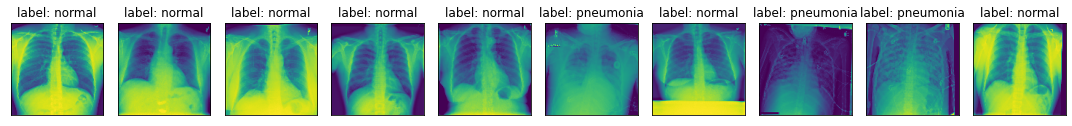

In [9]:
visualize_image(test_imgs, test_labels)

### Training class distribution

From the bar plot, we can clearly see that there is a clear class imbalance in the training dataset. There is a very large number of occurances of **'Normal'** and **Pneumonia'** class compared to **'COVID-19'** class. This imbalance would likely affect any model that is built and trained on this dataset. We may need to explore some approaches for data augmentation. But we will look into that later.

<BarContainer object of 3 artists>

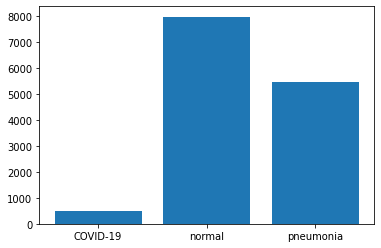

In [10]:
plt.bar(np.unique(train_labels, return_counts=True)[0], np.unique(train_labels, return_counts=True)[1])

<BarContainer object of 3 artists>

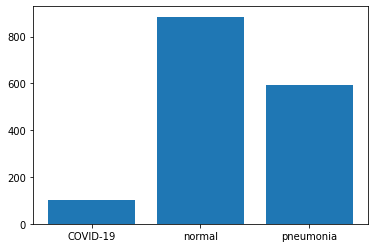

In [11]:
plt.bar(np.unique(test_labels, return_counts=True)[0], np.unique(test_labels, return_counts=True)[1])

# Data Pre-processing

Principle Component Analysis (PCA) has two important requirements:
1. The number of samples has to be quite larger than the number of dimensions.
2. The images must be vectorized.

The native image size of our dataset is 128px by 128px. Which means when vectorized, the number of dimensions will be 16384. Which is a lot bigger than the total sample we have for training, 13942. For that reason, we will resize the images to 64x64 pixels, which is a reasonable size to work with. We are hoping this size will retain some of the distinguishing features and will help us to separate the classes. Then we will vectorize our image sets. So it will be number of images by total number of dimensions.```Training set dimensions: 13942 x 4096``` and ```Test set dimensionss: 1579 x 4096```.

## Image resizing function

In [12]:
def resize_images(IMG_SET, HEIGHT, WIDTH):
    imgs = []
    for img in tqdm(IMG_SET, leave=False, desc='Resizing images: ', ncols='100%'):
        resized_img = cv2.resize(img, dsize=(HEIGHT, WIDTH), interpolation=cv2.INTER_CUBIC)
        imgs.append(resized_img)
        
    imgs = np.array(imgs)    
    return imgs

In [13]:
train_imgs_resized = resize_images(train_imgs, 64, 64)

In [14]:
test_imgs_resized = resize_images(test_imgs, 64, 64)

In [15]:
print(f'New dataset size:\nHEIGHT: {train_imgs_resized.shape[1]}\nWIDTH: {train_imgs_resized.shape[2]}')

New dataset size:
HEIGHT: 64
WIDTH: 64


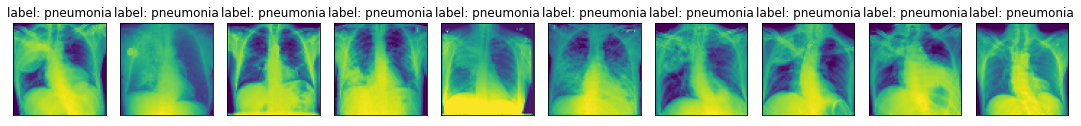

In [16]:
visualize_image(train_imgs_resized, train_labels)

## Image vectorizing function

In [17]:
def vectorise_img(IMG_SET):
    shp_dim1 = len(IMG_SET)
    shp_dim2 = IMG_SET.shape[1]*IMG_SET.shape[2]
    imgs = np.reshape(IMG_SET, (shp_dim1, shp_dim2))
    
    return imgs

In [18]:
train_imgs_vector = vectorise_img(train_imgs_resized)
test_imgs_vector = vectorise_img(test_imgs_resized)

In [19]:
print(f'New dataset size:\nROW: {train_imgs_vector.shape[0]}\nCOL: {train_imgs_vector.shape[1]}')

New dataset size:
ROW: 13942
COL: 4096


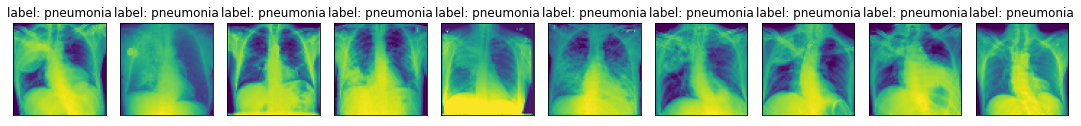

In [20]:
visualize_image(train_imgs_vector, train_labels)

# Principle Component Analysis (PCA)

* Principal component analysis (PCA) finds a new set of dimensions into which we reproject the data. This can be seen as rotating the data around the current axes.
* The new dimensions are oriented such that the first one captures the most possible variation, the second one captures the second most variation, etc
* The new axis are orthogonal to each other (i.e. at right angles)
* We get back as many principal components as we have original dimensions (i.e. we don't have to reduce the dimensions)
* We can project points into and out of our PCA space, reprojecting back out will give us our original data back
* PCA will subtract the mean from the data when computing the new set of axes. If we pass is non-centred data, PCA will remove the mean for us (and return it), otherwise we can do this before we pass it in.

## PCA implementation

In [21]:
# Creating the PCA object which will be used to fit and transform the data
pca = decomposition.PCA()

In [22]:
# Fitting and transforming the dataset
pca.fit(train_imgs_vector)
transformed = pca.transform(train_imgs_vector)

PCA calculates the ```Eigenvectors```, a unit vector representing the direction of variance in the data and ```Eigenvalues``` a scalar value for each eigenvector which represents the amount of variance in each component. We can access this value from out ```pca``` object. Let's examine some of these.

In [23]:
print("Components:")
print(f"Number of components we get back: {len(pca.components_)}")
print(pca.components_)
print()
print("Eignevalues:")
print(pca.explained_variance_)
print()
print("Percentage of variance explained:")
print(pca.explained_variance_ratio_)

Components:
Number of components we get back: 4096
[[ 1.06586858e-03  3.60309723e-03  4.04769059e-03 ...  1.92188751e-02
   1.66361591e-02  1.29946444e-02]
 [-1.25429103e-02 -1.20076844e-02 -1.24592514e-02 ...  2.54614986e-02
   2.15184057e-02  1.71698041e-02]
 [-2.18137179e-02 -8.18888884e-03 -6.08306373e-03 ...  1.84523504e-02
   2.02108989e-02  1.32831249e-02]
 ...
 [-7.17626779e-04  2.46773004e-03  5.09668796e-04 ... -1.72189210e-03
  -7.52053707e-05  8.42748304e-04]
 [-1.30025779e-03  2.46527494e-03 -9.17066499e-05 ... -5.17048250e-04
   3.49771146e-03 -5.11004175e-06]
 [-5.50240443e-04  5.95400136e-03 -6.40672010e-03 ... -4.50838817e-04
   1.01524465e-03 -1.03694024e-03]]

Eignevalues:
[2.31425768e+06 8.47554048e+05 7.11103130e+05 ... 1.84735045e+00
 1.84617583e+00 1.78059298e+00]

Percentage of variance explained:
[2.62729598e-01 9.62198532e-02 8.07290566e-02 ... 2.09723250e-07
 2.09589898e-07 2.02144506e-07]


```explained_variance_ratio_``` describes the percetnage of variance explained by each new dimension. We can plot this as a cumulative sum to visualize what each dimension contribute to explaining the variance.

## PCA visualization

Text(0.5, 1.0, 'First Two PCA Components')

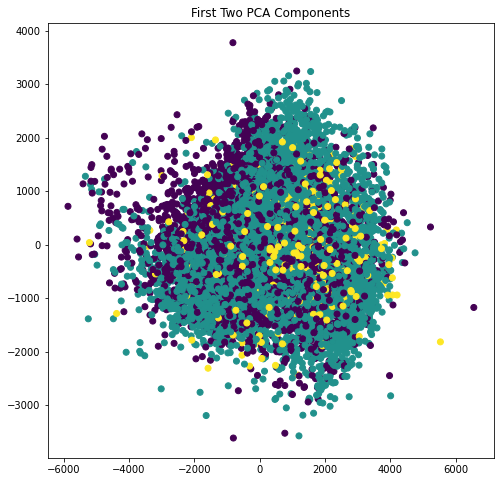

In [30]:
y = recode_labels(train_labels)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_train_95[:,0], transformed_train_95[:,1], c=y);
ax.set_title('First Two PCA Components')

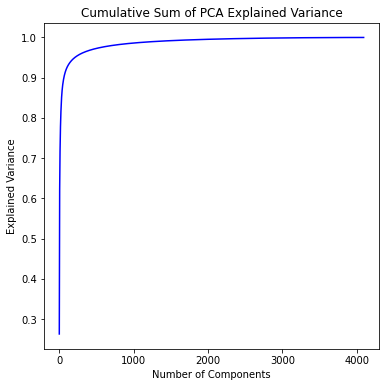

In [27]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum, c = 'b')
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

plt.show()

In [28]:
top90 = np.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = np.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = np.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 63 components
95% in 209 components
99% in 1287 components


When we look at the number of dimensions that it takes to explain 90%, 95% and 99% of the variance, we see that only 63 components are required to explain 90% of the variance. 209 components describes up to 95% of the variance. And 1287 components describes 99% of the variance, which is almost all of the data. So, this leads us to believe that we can dramatically reduce the dimensionality of the dataset and can work with even the first 63 or 209 components. So we will select the first 209 components from the transformed data.

In [29]:
transformed_train_95 = transformed[:, 0:top95]

transformed_test = pca.transform(test_imgs_vector)
transformed_test_95 = transformed_test[:, 0:top95]

distance = np.sqrt(np.sum((transformed_train_95 - transformed_test_95[0,:])**2, axis=1))

index_min = np.argmin(distance)

print(train_labels[index_min])
print(test_labels[0])

normal
normal


# Linear Discriminant Analysis (LDA)

LDA is used to separate the classes and make the class boundary more apparent. So we will combine LDA with PCA to better divide up the classes.

In [31]:
# Codeblock to recode the data. Not necessary for the classifiers.
def recode_labels(labels):
    code_dict = {'pneumonia':1, 'normal': 2, 'COVID-19': 3}
    return np.array([code_dict[label] for label in labels])

y = recode_labels(train_labels)

In [32]:
pca_coeff_for_lda = 4096 - len(np.unique(train_labels))
print(pca_coeff_for_lda)
transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

4093


Text(0.5, 1.0, 'First Two LDA Components')

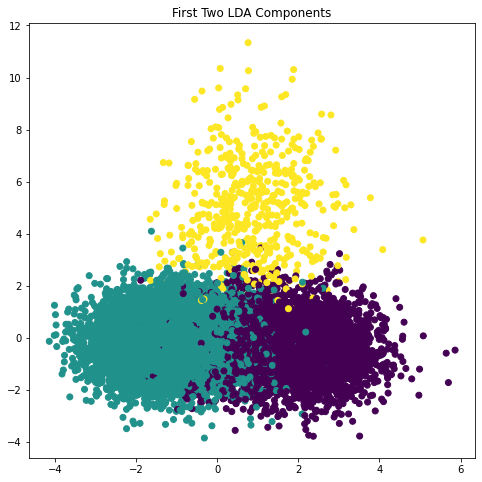

In [33]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(transformed_train_for_lda, train_labels)
lda_train = lda.transform(transformed_train_for_lda)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lda_train[:,0], lda_train[:,1], c=y);
ax.set_title('First Two LDA Components')

In [34]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))

# Image Classification
## K-nearest Neighbor Classifier

In [35]:
# train_labels = recode_labels(train_labels)
# train_labels = np.reshape(train_labels, -1)

# test_labels = recode_labels(test_labels)
# test_labels = np.reshape(test_labels, -1)

### KNN Classifier with PCA implementation

Test Accuracy: 0.8017732742241925


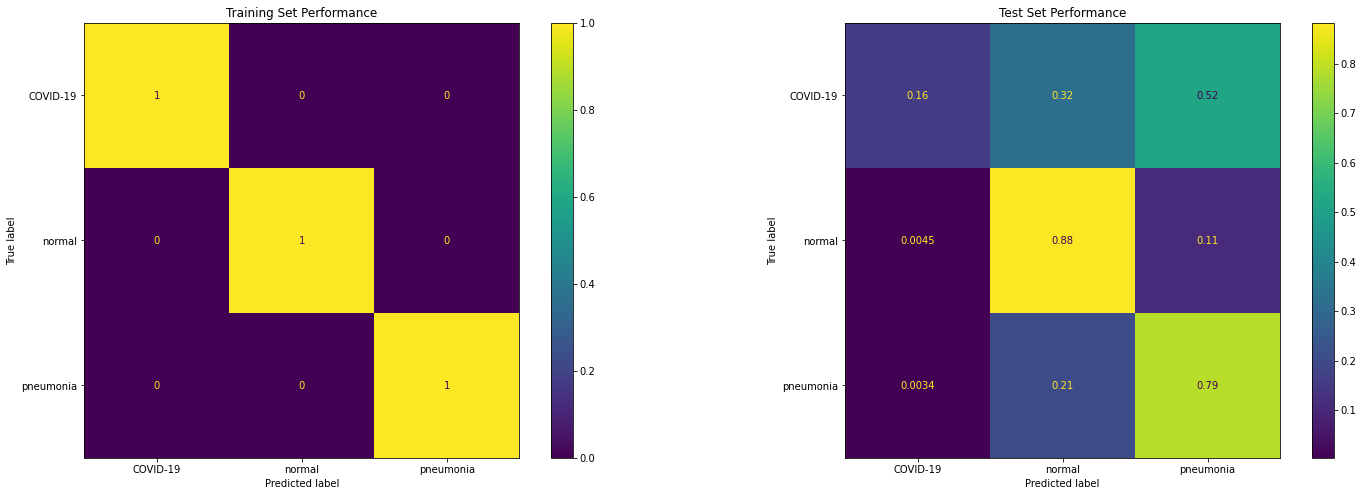

In [36]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(transformed_train_95, train_labels)
eval_model(cknn, transformed_train_95, train_labels, transformed_test_95, test_labels)

### KNN Classifier with PCA+LDA implementation

In [37]:
lda_test = lda.transform(transformed_test_for_lda)

Test Accuracy: 0.7327422419252692


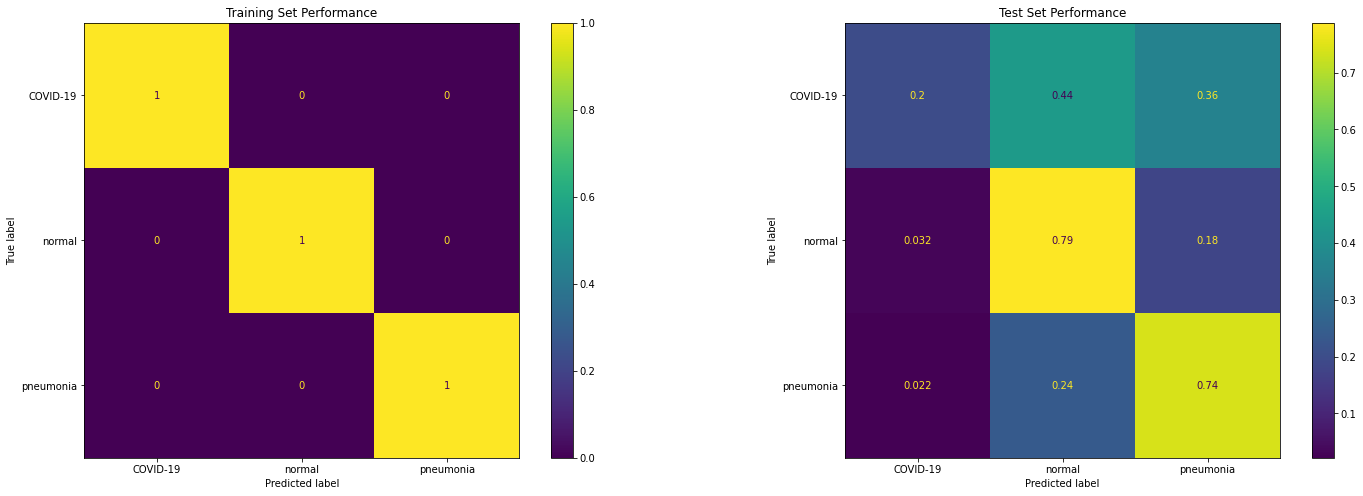

In [38]:
cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm = 'kd_tree')
cknn_lda.fit(lda_train, train_labels)
eval_model(cknn_lda, lda_train, train_labels, lda_test, test_labels)

### KNN Classifier with just LDA implementation

Test Accuracy: 0.7359088030398987


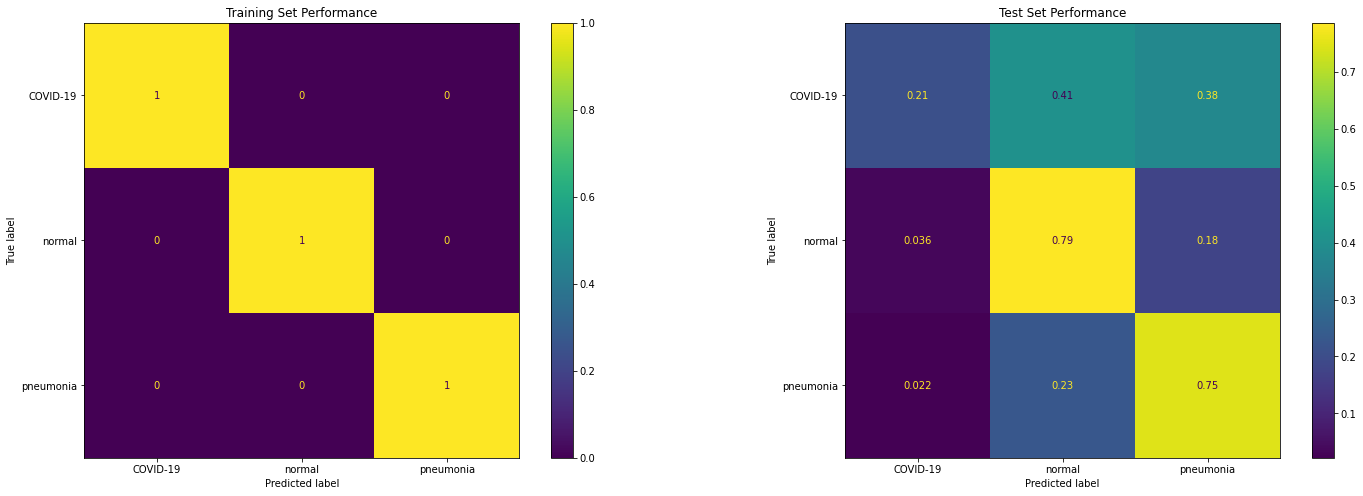

In [39]:
lda_only = discriminant_analysis.LinearDiscriminantAnalysis()
lda_only.fit(train_imgs_vector, train_labels)
lda_only_train = lda_only.transform(train_imgs_vector)
lda_only_test = lda_only.transform(test_imgs_vector)

cknn_lda_only = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm = 'kd_tree')
cknn_lda_only.fit(lda_only_train, train_labels)
eval_model(cknn_lda_only, lda_only_train, train_labels, lda_only_test, test_labels)

# Image Classification 2
## Support Vector Machine Classifier

### SVM Classifier with PCA implementation

[LibSVM]Test Accuracy: 0.5630145661811273


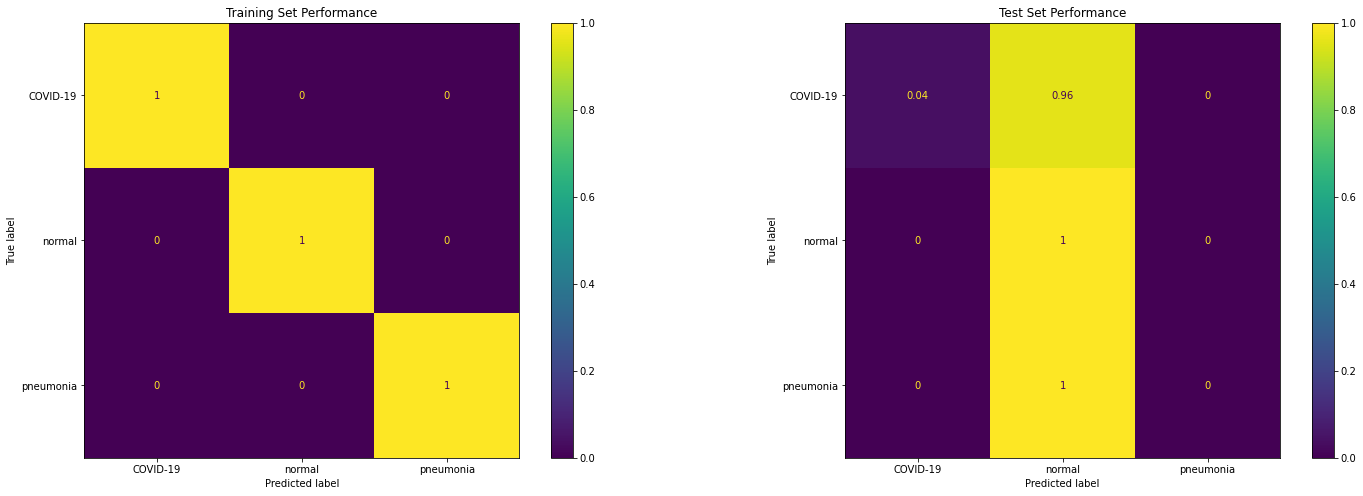

In [40]:
#create the support vectore clasifier in rbf kernel & fit the model
clf = svm.SVC(gamma = 0.001, C = 100, kernel = 'rbf', verbose = 1)
clf.fit(transformed_train_95, train_labels)
eval_model(clf, transformed_train_95, train_labels, transformed_test_95, test_labels)

Test Accuracy: 0.5699810006333123


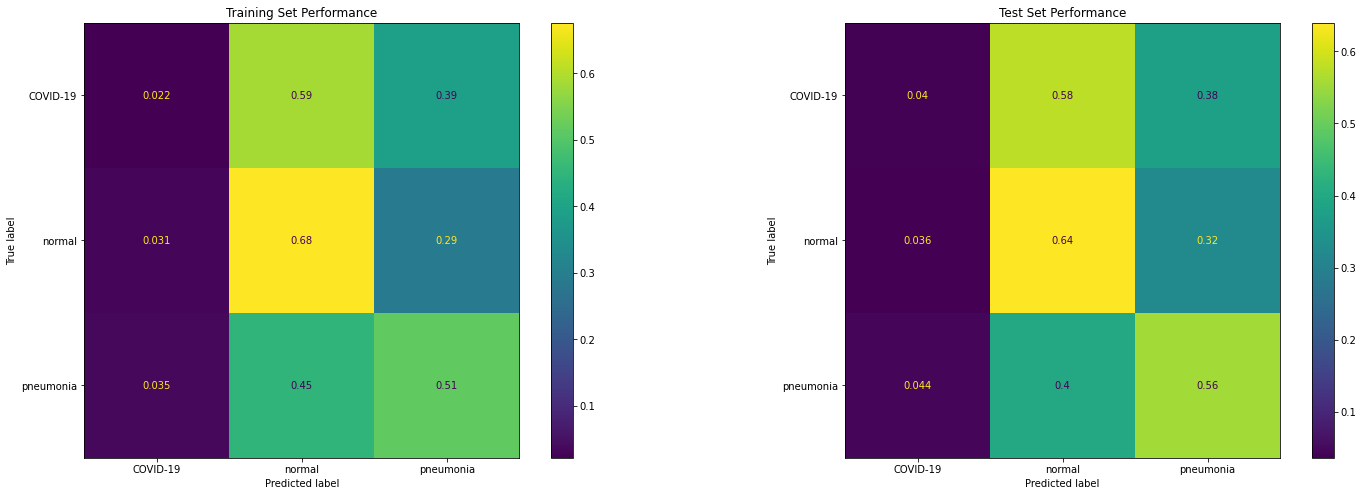

In [52]:
#create the support vectore clasifier in linear kernel & fit the model
clf_sig = svm.SVC(gamma = 0.001, C = 100, kernel = 'sigmoid', verbose = 1)

#fit the model
clf_sig.fit(transformed_train_95, train_labels)
eval_model(clf_sig, transformed_train_95, train_labels, transformed_test_95, test_labels)

In [53]:
clf_ln = svm.SVC(gamma = 0.001, C = 100, kernel = 'linear', verbose = 1)


In [ ]:
clf_ln.fit(transformed_train_95, train_labels)


[LibSVM]

In [ ]:
#create the support vectore clasifier in linear kernel & fit the model

#fit the model
eval_model(clf_ln, transformed_train_95, train_labels, transformed_test_95, test_labels)

### SVM Classifier with PCA+LDA implementation

In [41]:
lda_test = lda.transform(transformed_test_for_lda)

[LibSVM]Test Accuracy: 0.7441418619379354


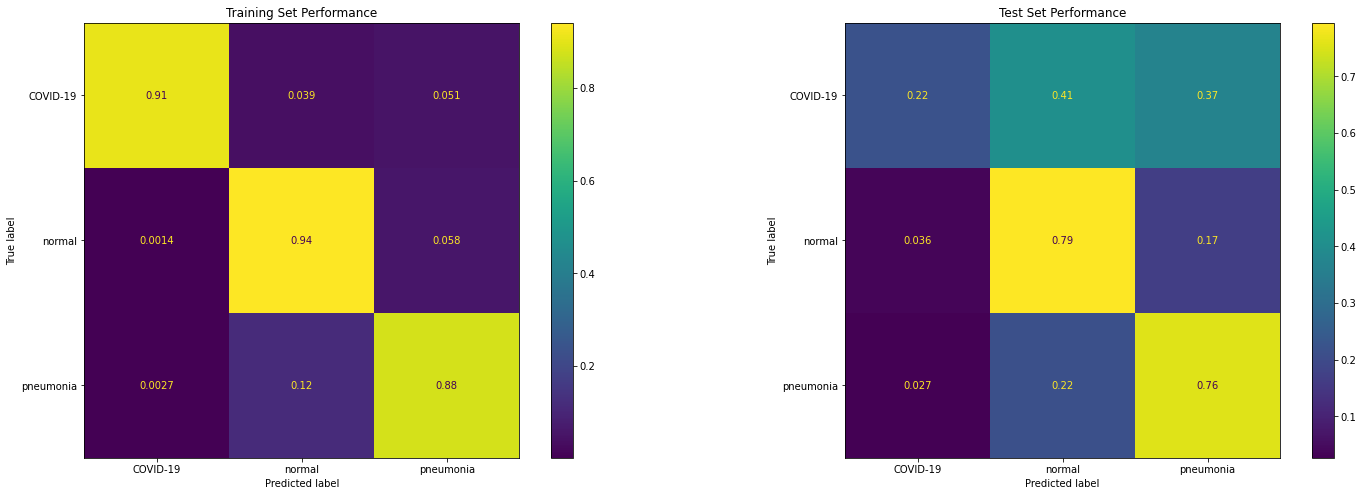

In [42]:
clf_lda = svm.SVC(gamma = 0.001, C = 100, kernel = 'rbf', verbose = 1)
clf_lda.fit(lda_train, train_labels)
eval_model(clf_lda, lda_train, train_labels, lda_test, test_labels)

### SVM Classifier with just LDA implementation

Test Accuracy: 0.7460417986067132


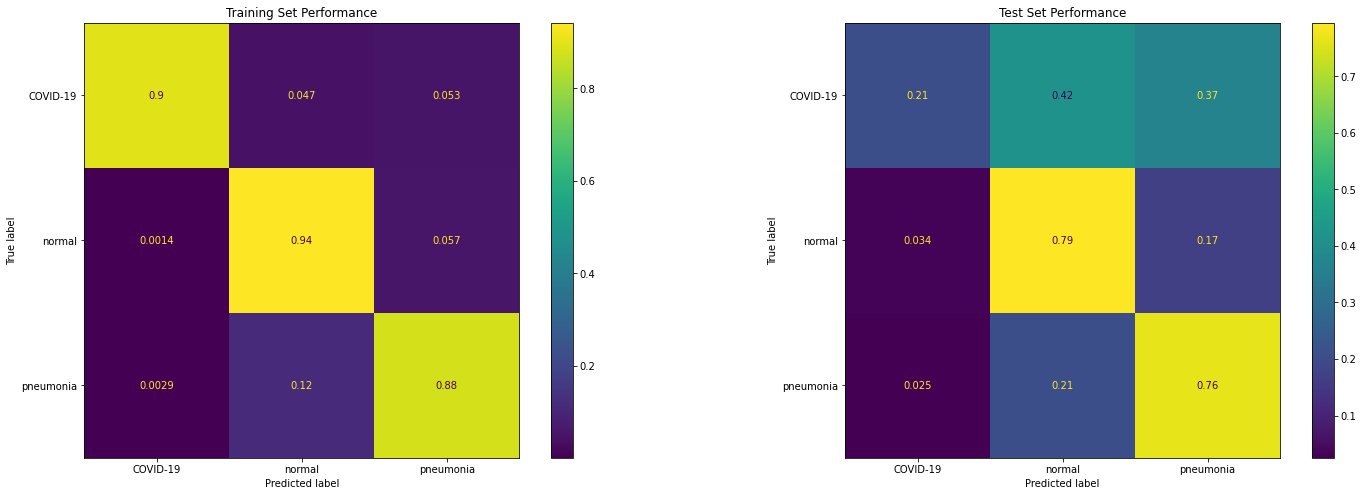

In [43]:
# Define the NaiveBayes Gaussian kernel
model_lda_only = GaussianNB()

# Fit a model to the data -> learning the model
model_lda_only.fit( lda_train, train_labels )
eval_model(model_lda_only,  lda_only_train, train_labels, lda_only_test, test_labels)

# Image Classification 3
## Naive Bayes Classifier

### NB Classifier with PCA implementation

Test Accuracy: 0.6706776440785307


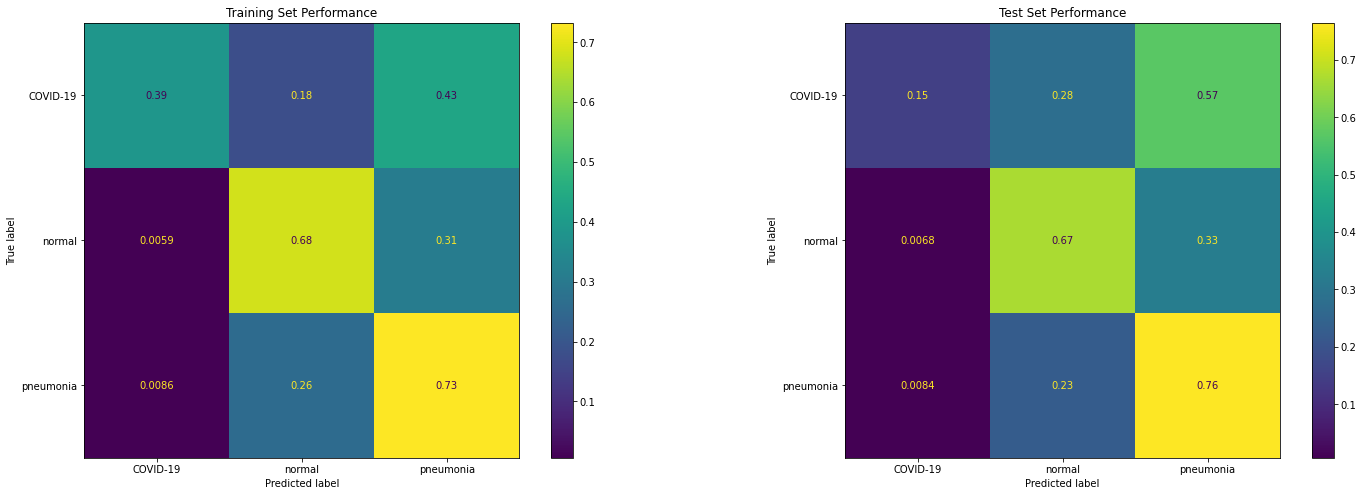

In [44]:
# Define the NaiveBayes Gaussian kernel
model = GaussianNB()

# Fit a model to the data -> learning the model
model.fit( transformed_train_95, train_labels )
eval_model(model, transformed_train_95, train_labels, transformed_test_95, test_labels)

### NB Classifier with PCA+LDA implementation

Test Accuracy: 0.7460417986067132


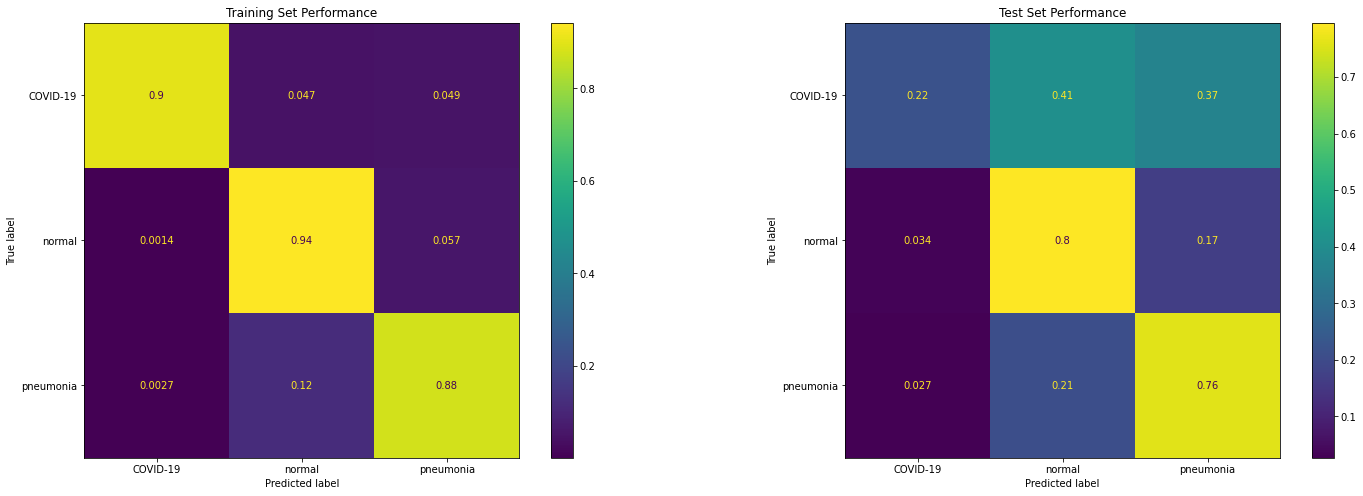

In [46]:
# Define the NaiveBayes Gaussian kernel
model_lda = GaussianNB()

# Fit a model to the data -> learning the model
model_lda.fit( lda_train, train_labels )
eval_model(model_lda, lda_train, train_labels, lda_test, test_labels)

### NB Classifier with just LDA implementation

Test Accuracy: 0.7460417986067132


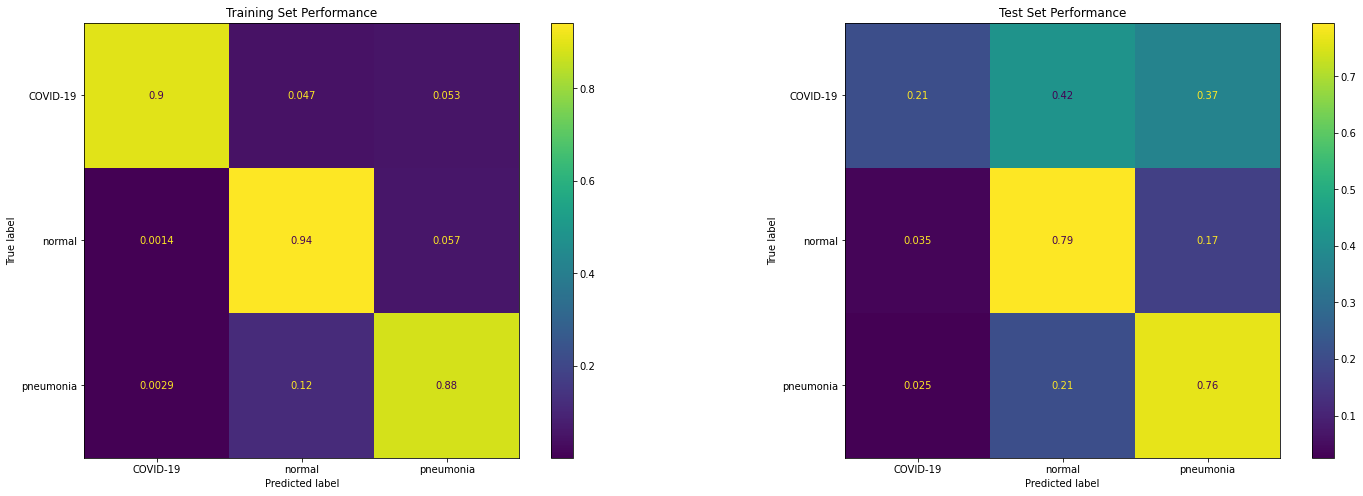

In [49]:
# Define the NaiveBayes Gaussian kernel
model_lda_only = GaussianNB()

# Fit a model to the data -> learning the model
model_lda_only.fit( lda_only_train, train_labels )
eval_model(model_lda_only,  lda_only_train, train_labels, lda_only_test, test_labels)